<a href="https://colab.research.google.com/github/Fatemehss94/amlg/blob/main/src/exercises/perturbation_data_analysis/project_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pwd

'/content'

In [2]:
ls

sample_data/


In [3]:
!git clone https://github.com/voges/amlg.git

Cloning into 'amlg'...
remote: Enumerating objects: 1063, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1063 (delta 7), reused 11 (delta 6), pack-reused 1049 (from 1)
Receiving objects: 100% (1063/1063), 11.80 MiB | 26.98 MiB/s, done.
Resolving deltas: 100% (612/612), done.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from tqdm import tqdm

In [8]:
import pertdata as pt

norman = pt.PertData.from_repo(name="norman", save_dir="data")

Creating dataset directory: data/norman
Downloading: https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fperturbation_data_analysis%2Fnorman%2Fperturb_processed.h5ad&dl=1 -> data/norman/perturb_processed.h5ad
Total size: 2,228,610,012 bytes


100%|██████████| 2.23G/2.23G [01:41<00:00, 21.9MiB/s]


Download completed: data/norman/perturb_processed.h5ad
Loading dataset: norman


In [9]:
print(norman)
print(norman.adata)

X = norman.adata.X
y_pert = norman.adata.obs["condition"]
y_ctrl = norman.adata.obs["control"]
gene_names = norman.adata.var["gene_name"]

print(f"X.shape={X.shape}")
print(f"y_pert.shape={y_pert.shape}")
print(f"y_ctrl.shape={y_ctrl.shape}")
print(f"gene_names.shape={gene_names.shape}")

PertData object
    name: norman
    path: data/norman
    adata: AnnData object with n_obs x n_vars = 91205 x 5045
AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'
X.shape=(91205, 5045)
y_pert.shape=(91205,)
y_ctrl.shape=(91205,)
gene_names.shape=(5045,)


In [10]:
# first ndices of fixed_condition to remove gene+ctrl
# then retrive indices of labels, thet do not contain + (indicating double-gene perturbations)
filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+")
indexes_to_keep = filter_mask[filter_mask].index
adata_single = norman.adata[indexes_to_keep].copy() # create a new datasets that contains only the singe perturbations

In [11]:
# Number of top genes to select
d = 128
# Compute the gene variances
gene_variances = adata_single.X.toarray().var(axis=0)
# Sort the gene variances in descending order and get the indexes of the top d genes
sorted_indexes = gene_variances.argsort()[::-1]
# Get the indexes of the top d genes
top_gene_indexes = sorted_indexes[:d]
# Get the gene names of the top d genes
top_genes = adata_single.var["gene_name"].iloc[top_gene_indexes]
# Get the variances of the top d genes
top_variances = gene_variances[top_gene_indexes]
# Create a new AnnData object with only the top d genes
adata_single_top_genes = adata_single[:, top_gene_indexes].copy()

In [12]:
# Convert the gene expression matrix to a PyTorch tensor
X = torch.tensor(data=adata_single_top_genes.X.toarray(), dtype=torch.float32)

# Create a PyTorch dataset
dataset = TensorDataset(X, X)

# Create train and test datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(
    dataset=dataset, lengths=[train_size, test_size]
)

# Fix: Set num_workers > 0 or disable persistent_workers
num_workers = 2  # Set to a positive integer
persistent_workers = False  # Disable if num_workers is 0

# Train DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=persistent_workers,
)

# Test DataLoader
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=persistent_workers,
)


In [13]:
# Get the number of features
n_features = X.shape[1]
print(f"n_features={n_features}")

# Get the number of samples
n_samples = X.shape[0]  # = len(train_dataset) + len(test_dataset) = len(dataset)
print(f"n_samples={n_samples}")

n_features=128
n_samples=55760


**Create an Autoencoder for dimensionality reduction**

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

    def forward(self, z):
        return self.decoder(z)


# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

**train Autoencoder to produce 64 D latents**

In [30]:
# Set dimensions
input_dim = X.shape[1]
latent_dim = 64 # For visualization purposes

# Initialize the Autoencoder
autoencoder = Autoencoder(input_dim, latent_dim)

# Define the training function
def train_autoencoder(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  # Add progress bar
        for inputs, _ in progress_bar:
            inputs = inputs.view(inputs.size(0), -1)  # Flatten input for linear layers
            optimizer.zero_grad()
            outputs, z = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Update the progress bar with the current loss
            progress_bar.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")

# Set up the optimizer and loss function
num_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)


# Train the autoencoder with progress bar
train_autoencoder(autoencoder, train_loader, optimizer, criterion, num_epochs)


Epoch 1/100: 100%|██████████| 697/697 [00:13<00:00, 50.38it/s, loss=0.25]


Epoch 1/100, Loss: 0.3221826895622475


Epoch 2/100: 100%|██████████| 697/697 [00:16<00:00, 42.25it/s, loss=0.187]


Epoch 2/100, Loss: 0.20432435692297335


Epoch 3/100: 100%|██████████| 697/697 [00:16<00:00, 42.77it/s, loss=0.144]


Epoch 3/100, Loss: 0.16680519729638887


Epoch 4/100: 100%|██████████| 697/697 [00:16<00:00, 42.09it/s, loss=0.145]


Epoch 4/100, Loss: 0.14918220597967355


Epoch 5/100: 100%|██████████| 697/697 [00:16<00:00, 41.03it/s, loss=0.162]


Epoch 5/100, Loss: 0.1398947520269725


Epoch 6/100: 100%|██████████| 697/697 [00:16<00:00, 41.39it/s, loss=0.133]


Epoch 6/100, Loss: 0.13363316011651175


Epoch 7/100: 100%|██████████| 697/697 [00:16<00:00, 42.06it/s, loss=0.125]


Epoch 7/100, Loss: 0.13017566545921214


Epoch 8/100: 100%|██████████| 697/697 [00:16<00:00, 42.43it/s, loss=0.121]


Epoch 8/100, Loss: 0.1290267643597581


Epoch 9/100: 100%|██████████| 697/697 [00:16<00:00, 42.51it/s, loss=0.124]


Epoch 9/100, Loss: 0.12826957968377656


Epoch 10/100: 100%|██████████| 697/697 [00:16<00:00, 42.61it/s, loss=0.13]


Epoch 10/100, Loss: 0.12741795971113093


Epoch 11/100: 100%|██████████| 697/697 [00:16<00:00, 42.60it/s, loss=0.135]


Epoch 11/100, Loss: 0.12693085385702946


Epoch 12/100: 100%|██████████| 697/697 [00:16<00:00, 42.71it/s, loss=0.126]


Epoch 12/100, Loss: 0.12644904469229398


Epoch 13/100: 100%|██████████| 697/697 [00:17<00:00, 40.85it/s, loss=0.118]


Epoch 13/100, Loss: 0.1260133668395505


Epoch 14/100: 100%|██████████| 697/697 [00:17<00:00, 40.73it/s, loss=0.128]


Epoch 14/100, Loss: 0.12573156453444592


Epoch 15/100: 100%|██████████| 697/697 [00:16<00:00, 41.92it/s, loss=0.121]


Epoch 15/100, Loss: 0.12533201322151907


Epoch 16/100: 100%|██████████| 697/697 [00:16<00:00, 42.99it/s, loss=0.111]


Epoch 16/100, Loss: 0.1250588983575275


Epoch 17/100: 100%|██████████| 697/697 [00:16<00:00, 42.67it/s, loss=0.118]


Epoch 17/100, Loss: 0.12487922172720839


Epoch 18/100: 100%|██████████| 697/697 [00:16<00:00, 42.22it/s, loss=0.122]


Epoch 18/100, Loss: 0.12460086834610277


Epoch 19/100: 100%|██████████| 697/697 [00:16<00:00, 42.97it/s, loss=0.125]


Epoch 19/100, Loss: 0.12447421085971329


Epoch 20/100: 100%|██████████| 697/697 [00:16<00:00, 42.16it/s, loss=0.124]


Epoch 20/100, Loss: 0.1241777950585145


Epoch 21/100: 100%|██████████| 697/697 [00:16<00:00, 41.36it/s, loss=0.126]


Epoch 21/100, Loss: 0.12411384470493585


Epoch 22/100: 100%|██████████| 697/697 [00:17<00:00, 40.95it/s, loss=0.126]


Epoch 22/100, Loss: 0.1239235719059256


Epoch 23/100: 100%|██████████| 697/697 [00:16<00:00, 42.64it/s, loss=0.128]


Epoch 23/100, Loss: 0.12365676860299651


Epoch 24/100: 100%|██████████| 697/697 [00:16<00:00, 42.55it/s, loss=0.14]


Epoch 24/100, Loss: 0.12359464864434949


Epoch 25/100: 100%|██████████| 697/697 [00:16<00:00, 42.83it/s, loss=0.133]


Epoch 25/100, Loss: 0.1233395748321432


Epoch 26/100: 100%|██████████| 697/697 [00:16<00:00, 43.09it/s, loss=0.122]


Epoch 26/100, Loss: 0.12297249119327948


Epoch 27/100: 100%|██████████| 697/697 [00:16<00:00, 42.43it/s, loss=0.134]


Epoch 27/100, Loss: 0.12278459985423806


Epoch 28/100: 100%|██████████| 697/697 [00:16<00:00, 42.47it/s, loss=0.127]


Epoch 28/100, Loss: 0.12267505673630166


Epoch 29/100: 100%|██████████| 697/697 [00:16<00:00, 42.97it/s, loss=0.124]


Epoch 29/100, Loss: 0.12241681624562019


Epoch 30/100: 100%|██████████| 697/697 [00:16<00:00, 41.46it/s, loss=0.114]


Epoch 30/100, Loss: 0.1222663213588415


Epoch 31/100: 100%|██████████| 697/697 [00:16<00:00, 41.18it/s, loss=0.133]


Epoch 31/100, Loss: 0.12210235841989175


Epoch 32/100: 100%|██████████| 697/697 [00:16<00:00, 41.28it/s, loss=0.12]


Epoch 32/100, Loss: 0.12179881746919459


Epoch 33/100: 100%|██████████| 697/697 [00:16<00:00, 42.64it/s, loss=0.127]


Epoch 33/100, Loss: 0.12156809707154845


Epoch 34/100: 100%|██████████| 697/697 [00:16<00:00, 42.29it/s, loss=0.114]


Epoch 34/100, Loss: 0.12146209430489342


Epoch 35/100: 100%|██████████| 697/697 [00:16<00:00, 42.81it/s, loss=0.133]


Epoch 35/100, Loss: 0.12126463072286275


Epoch 36/100: 100%|██████████| 697/697 [00:19<00:00, 35.34it/s, loss=0.127]


Epoch 36/100, Loss: 0.12107507988190548


Epoch 37/100: 100%|██████████| 697/697 [00:20<00:00, 34.73it/s, loss=0.128]


Epoch 37/100, Loss: 0.1208757188710968


Epoch 38/100: 100%|██████████| 697/697 [00:17<00:00, 40.96it/s, loss=0.114]


Epoch 38/100, Loss: 0.12072836679314267


Epoch 39/100: 100%|██████████| 697/697 [00:20<00:00, 34.17it/s, loss=0.119]


Epoch 39/100, Loss: 0.12054696574358208


Epoch 40/100: 100%|██████████| 697/697 [00:18<00:00, 38.57it/s, loss=0.122]


Epoch 40/100, Loss: 0.12060251387325216


Epoch 41/100: 100%|██████████| 697/697 [00:16<00:00, 42.21it/s, loss=0.12]


Epoch 41/100, Loss: 0.12036056490548201


Epoch 42/100: 100%|██████████| 697/697 [00:16<00:00, 42.25it/s, loss=0.126]


Epoch 42/100, Loss: 0.12038674919600124


Epoch 43/100: 100%|██████████| 697/697 [00:16<00:00, 42.08it/s, loss=0.119]


Epoch 43/100, Loss: 0.12006778854721759


Epoch 44/100: 100%|██████████| 697/697 [00:16<00:00, 42.51it/s, loss=0.121]


Epoch 44/100, Loss: 0.12002670205862313


Epoch 45/100: 100%|██████████| 697/697 [00:16<00:00, 41.09it/s, loss=0.125]


Epoch 45/100, Loss: 0.1198301860472051


Epoch 46/100: 100%|██████████| 697/697 [00:17<00:00, 39.44it/s, loss=0.117]


Epoch 46/100, Loss: 0.11973749224091192


Epoch 47/100: 100%|██████████| 697/697 [00:16<00:00, 42.35it/s, loss=0.116]


Epoch 47/100, Loss: 0.1195459361889612


Epoch 48/100: 100%|██████████| 697/697 [00:16<00:00, 41.83it/s, loss=0.115]


Epoch 48/100, Loss: 0.11928323102604539


Epoch 49/100: 100%|██████████| 697/697 [00:16<00:00, 41.38it/s, loss=0.134]


Epoch 49/100, Loss: 0.1192498950440025


Epoch 50/100: 100%|██████████| 697/697 [00:18<00:00, 38.14it/s, loss=0.12]


Epoch 50/100, Loss: 0.11917991939413668


Epoch 51/100: 100%|██████████| 697/697 [00:16<00:00, 41.52it/s, loss=0.124]


Epoch 51/100, Loss: 0.11888455415687055


Epoch 52/100: 100%|██████████| 697/697 [00:17<00:00, 40.21it/s, loss=0.119]


Epoch 52/100, Loss: 0.11876846406304169


Epoch 53/100: 100%|██████████| 697/697 [00:17<00:00, 39.75it/s, loss=0.112]


Epoch 53/100, Loss: 0.11863828569094796


Epoch 54/100: 100%|██████████| 697/697 [00:17<00:00, 40.47it/s, loss=0.113]


Epoch 54/100, Loss: 0.1184186453435308


Epoch 55/100: 100%|██████████| 697/697 [00:17<00:00, 40.25it/s, loss=0.122]


Epoch 55/100, Loss: 0.1182733522981961


Epoch 56/100: 100%|██████████| 697/697 [00:17<00:00, 39.98it/s, loss=0.117]


Epoch 56/100, Loss: 0.11821350397560826


Epoch 57/100: 100%|██████████| 697/697 [00:17<00:00, 39.35it/s, loss=0.107]


Epoch 57/100, Loss: 0.11798221499283652


Epoch 58/100: 100%|██████████| 697/697 [00:17<00:00, 38.97it/s, loss=0.116]


Epoch 58/100, Loss: 0.11768917174985795


Epoch 59/100: 100%|██████████| 697/697 [00:18<00:00, 37.47it/s, loss=0.116]


Epoch 59/100, Loss: 0.11765025487674702


Epoch 60/100: 100%|██████████| 697/697 [00:17<00:00, 38.95it/s, loss=0.112]


Epoch 60/100, Loss: 0.11745637128265893


Epoch 61/100: 100%|██████████| 697/697 [00:17<00:00, 38.94it/s, loss=0.121]


Epoch 61/100, Loss: 0.11713983046914447


Epoch 62/100: 100%|██████████| 697/697 [00:18<00:00, 38.23it/s, loss=0.121]


Epoch 62/100, Loss: 0.1169964297643864


Epoch 63/100: 100%|██████████| 697/697 [00:19<00:00, 36.33it/s, loss=0.128]


Epoch 63/100, Loss: 0.11660895928462574


Epoch 64/100: 100%|██████████| 697/697 [00:18<00:00, 37.40it/s, loss=0.132]


Epoch 64/100, Loss: 0.11629001968346504


Epoch 65/100: 100%|██████████| 697/697 [00:18<00:00, 37.19it/s, loss=0.11]


Epoch 65/100, Loss: 0.11596354230746649


Epoch 66/100: 100%|██████████| 697/697 [00:18<00:00, 36.88it/s, loss=0.117]


Epoch 66/100, Loss: 0.11577687598497659


Epoch 67/100: 100%|██████████| 697/697 [00:19<00:00, 35.02it/s, loss=0.109]


Epoch 67/100, Loss: 0.11534770912727291


Epoch 68/100: 100%|██████████| 697/697 [00:18<00:00, 36.94it/s, loss=0.117]


Epoch 68/100, Loss: 0.11510948185812965


Epoch 69/100: 100%|██████████| 697/697 [00:18<00:00, 36.80it/s, loss=0.12]


Epoch 69/100, Loss: 0.11501184853069067


Epoch 70/100: 100%|██████████| 697/697 [00:19<00:00, 35.23it/s, loss=0.107]


Epoch 70/100, Loss: 0.11444379295218453


Epoch 71/100: 100%|██████████| 697/697 [00:19<00:00, 35.83it/s, loss=0.103]


Epoch 71/100, Loss: 0.11447338278871698


Epoch 72/100: 100%|██████████| 697/697 [00:19<00:00, 36.52it/s, loss=0.102]


Epoch 72/100, Loss: 0.11413327804425867


Epoch 73/100: 100%|██████████| 697/697 [00:19<00:00, 35.76it/s, loss=0.117]


Epoch 73/100, Loss: 0.11410284752141113


Epoch 74/100: 100%|██████████| 697/697 [00:19<00:00, 34.90it/s, loss=0.106]


Epoch 74/100, Loss: 0.11392000115542023


Epoch 75/100: 100%|██████████| 697/697 [00:19<00:00, 35.97it/s, loss=0.11]


Epoch 75/100, Loss: 0.11371231667023991


Epoch 76/100: 100%|██████████| 697/697 [00:19<00:00, 35.32it/s, loss=0.114]


Epoch 76/100, Loss: 0.11353967796310975


Epoch 77/100: 100%|██████████| 697/697 [00:20<00:00, 34.34it/s, loss=0.116]


Epoch 77/100, Loss: 0.1135219247581456


Epoch 78/100: 100%|██████████| 697/697 [00:19<00:00, 35.29it/s, loss=0.12]


Epoch 78/100, Loss: 0.11330096496314537


Epoch 79/100: 100%|██████████| 697/697 [00:20<00:00, 34.83it/s, loss=0.109]


Epoch 79/100, Loss: 0.11301898136414278


Epoch 80/100: 100%|██████████| 697/697 [00:20<00:00, 33.67it/s, loss=0.111]


Epoch 80/100, Loss: 0.11301051305775321


Epoch 81/100: 100%|██████████| 697/697 [00:19<00:00, 34.98it/s, loss=0.113]


Epoch 81/100, Loss: 0.11275918228041322


Epoch 82/100: 100%|██████████| 697/697 [00:20<00:00, 33.70it/s, loss=0.12]


Epoch 82/100, Loss: 0.11271293489115482


Epoch 83/100: 100%|██████████| 697/697 [00:20<00:00, 33.78it/s, loss=0.127]


Epoch 83/100, Loss: 0.1126202767022713


Epoch 84/100: 100%|██████████| 697/697 [00:20<00:00, 34.43it/s, loss=0.111]


Epoch 84/100, Loss: 0.1125000165494819


Epoch 85/100: 100%|██████████| 697/697 [00:21<00:00, 32.28it/s, loss=0.109]


Epoch 85/100, Loss: 0.1123339650535173


Epoch 86/100: 100%|██████████| 697/697 [00:20<00:00, 33.93it/s, loss=0.112]


Epoch 86/100, Loss: 0.1123250721602392


Epoch 87/100: 100%|██████████| 697/697 [00:22<00:00, 31.68it/s, loss=0.119]


Epoch 87/100, Loss: 0.11234049495828032


Epoch 88/100: 100%|██████████| 697/697 [00:20<00:00, 33.71it/s, loss=0.116]


Epoch 88/100, Loss: 0.11207810538143476


Epoch 89/100: 100%|██████████| 697/697 [00:21<00:00, 32.97it/s, loss=0.116]


Epoch 89/100, Loss: 0.11201831749727258


Epoch 90/100: 100%|██████████| 697/697 [00:21<00:00, 32.44it/s, loss=0.117]


Epoch 90/100, Loss: 0.11186309730690214


Epoch 91/100: 100%|██████████| 697/697 [00:20<00:00, 33.86it/s, loss=0.119]


Epoch 91/100, Loss: 0.11181128267706553


Epoch 92/100: 100%|██████████| 697/697 [00:21<00:00, 31.70it/s, loss=0.101]


Epoch 92/100, Loss: 0.1117286816495905


Epoch 93/100: 100%|██████████| 697/697 [00:21<00:00, 32.91it/s, loss=0.109]


Epoch 93/100, Loss: 0.11175650343234775


Epoch 94/100: 100%|██████████| 697/697 [00:22<00:00, 31.29it/s, loss=0.11]


Epoch 94/100, Loss: 0.11159156360149042


Epoch 95/100: 100%|██████████| 697/697 [00:21<00:00, 33.00it/s, loss=0.106]


Epoch 95/100, Loss: 0.11145283812002267


Epoch 96/100: 100%|██████████| 697/697 [00:21<00:00, 32.15it/s, loss=0.114]


Epoch 96/100, Loss: 0.11136976976904328


Epoch 97/100: 100%|██████████| 697/697 [00:21<00:00, 33.14it/s, loss=0.123]


Epoch 97/100, Loss: 0.11136835760074845


Epoch 98/100: 100%|██████████| 697/697 [00:21<00:00, 32.39it/s, loss=0.107]


Epoch 98/100, Loss: 0.11121442607220482


Epoch 99/100: 100%|██████████| 697/697 [00:21<00:00, 31.74it/s, loss=0.109]


Epoch 99/100, Loss: 0.11093984520760294


Epoch 100/100: 100%|██████████| 697/697 [00:20<00:00, 33.45it/s, loss=0.108]

Epoch 100/100, Loss: 0.11101189535779282


**visualise 2D latents for the most intensive fixed condition**

**convert 64D to 2D using PCA**

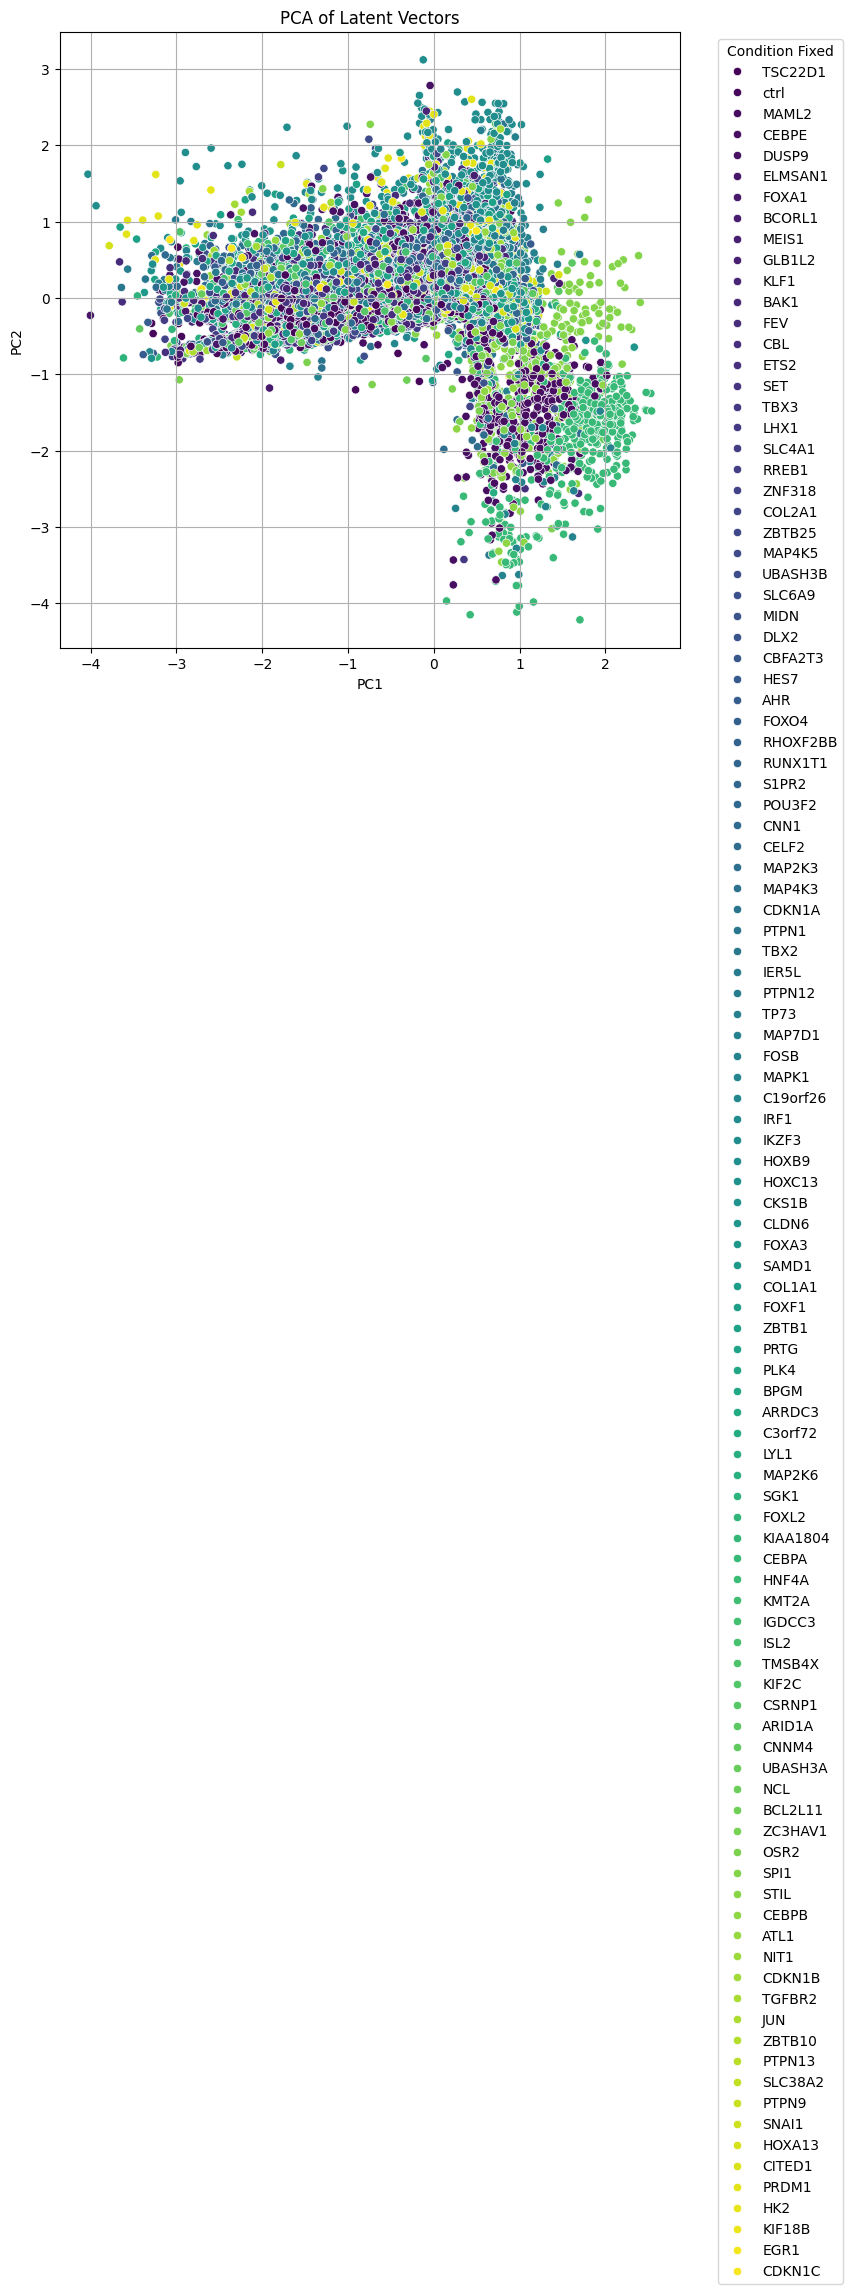

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Apply PCA to reduce the latent vectors to 2 dimensions
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z)

# Visualize the 2D PCA results using seaborn.scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=condition_fixed, palette="viridis") # Use seaborn.scatterplot
plt.title("PCA of Latent Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(title="Condition Fixed", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [45]:
import pandas as pd
# Count the number of rows per unique fixed condition
condition_counts = pd.value_counts(condition_fixed)

# Print the counts
print("Number of rows per unique fixed condition:")
print(condition_counts)

Number of rows per unique fixed condition:
ctrl      7353
KLF1      1641
BAK1      1171
CEBPE     1039
ETS2      1031
          ... 
NIT1       165
CDKN1C     165
ZBTB10     145
HES7       122
PLK4        97
Name: count, Length: 106, dtype: int64


<ipython-input-45-dc25b816cca8>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  condition_counts = pd.value_counts(condition_fixed)


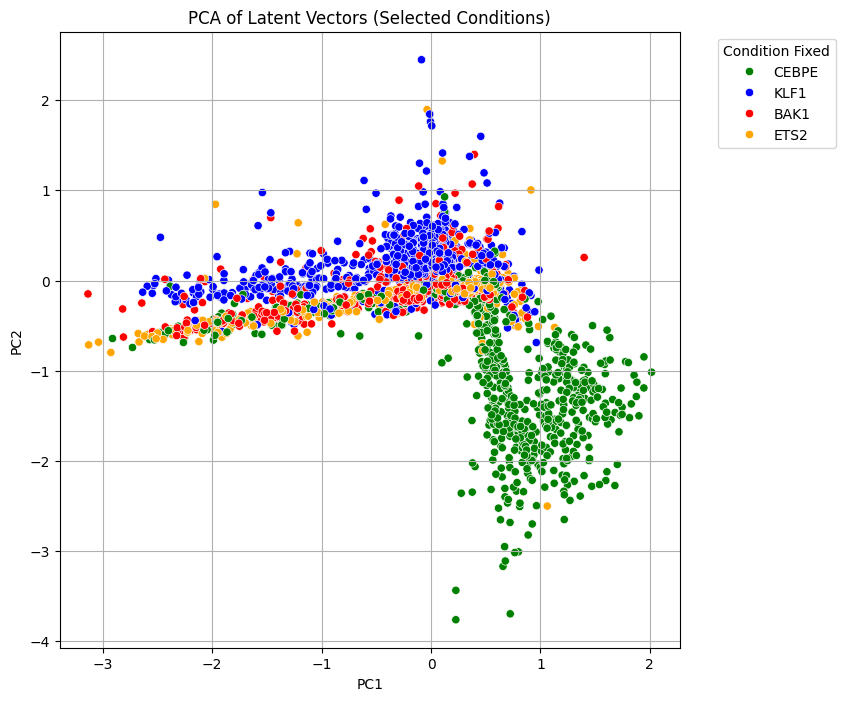

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA


# Apply PCA to reduce the latent vectors to 2 dimensions
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z)

# Filter data for specific condition_fixed values
selected_conditions = ["KLF1", "BAK1", "CEBPE", "ETS2"]
filter_mask = np.isin(condition_fixed, selected_conditions)
filtered_z_2d = z_2d[filter_mask]
filtered_condition_fixed = condition_fixed[filter_mask]

# Define a custom color palette with distinct colors
custom_palette = {"KLF1": "blue", "BAK1": "red", "CEBPE": "green", "PLK4": "orange"}

# Visualize the 2D PCA results using seaborn.scatterplot with custom palette
plt.figure(figsize=(8, 8))
sns.scatterplot(x=filtered_z_2d[:, 0], y=filtered_z_2d[:, 1],
                hue=filtered_condition_fixed, palette=custom_palette)
plt.title("PCA of Latent Vectors (Selected Conditions)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(title="Condition Fixed", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**train autencode to produce 2D latents**

In [48]:
latent_dim = 2 # For visualization purposes

# Initialize the Autoencoder
autoencoder = Autoencoder(input_dim, latent_dim)

# Set up the optimizer and loss function
num_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder with progress bar
train_autoencoder(autoencoder, train_loader, optimizer, criterion, num_epochs)

Epoch 1/100: 100%|██████████| 697/697 [00:15<00:00, 45.15it/s, loss=0.33]


Epoch 1/100, Loss: 0.37894128239479774


Epoch 2/100: 100%|██████████| 697/697 [00:17<00:00, 40.92it/s, loss=0.334]


Epoch 2/100, Loss: 0.3395929946276858


Epoch 3/100: 100%|██████████| 697/697 [00:16<00:00, 42.09it/s, loss=0.334]


Epoch 3/100, Loss: 0.3346664231682097


Epoch 4/100: 100%|██████████| 697/697 [00:16<00:00, 42.14it/s, loss=0.315]


Epoch 4/100, Loss: 0.3319270403433051


Epoch 5/100: 100%|██████████| 697/697 [00:16<00:00, 42.08it/s, loss=0.328]


Epoch 5/100, Loss: 0.32973697768735405


Epoch 6/100: 100%|██████████| 697/697 [00:16<00:00, 42.00it/s, loss=0.324]


Epoch 6/100, Loss: 0.3295194396757156


Epoch 7/100: 100%|██████████| 697/697 [00:17<00:00, 39.98it/s, loss=0.338]


Epoch 7/100, Loss: 0.3269949392489073


Epoch 8/100: 100%|██████████| 697/697 [00:17<00:00, 40.45it/s, loss=0.343]


Epoch 8/100, Loss: 0.32609245933624387


Epoch 9/100: 100%|██████████| 697/697 [00:17<00:00, 39.05it/s, loss=0.339]


Epoch 9/100, Loss: 0.32505912281348337


Epoch 10/100: 100%|██████████| 697/697 [00:17<00:00, 40.94it/s, loss=0.338]


Epoch 10/100, Loss: 0.3236651706216667


Epoch 11/100: 100%|██████████| 697/697 [00:17<00:00, 40.88it/s, loss=0.326]


Epoch 11/100, Loss: 0.32366130983128266


Epoch 12/100: 100%|██████████| 697/697 [00:17<00:00, 40.39it/s, loss=0.325]


Epoch 12/100, Loss: 0.3228948237735196


Epoch 13/100: 100%|██████████| 697/697 [00:17<00:00, 40.21it/s, loss=0.315]


Epoch 13/100, Loss: 0.32209700658126406


Epoch 14/100: 100%|██████████| 697/697 [00:18<00:00, 38.22it/s, loss=0.311]


Epoch 14/100, Loss: 0.3219940267300161


Epoch 15/100: 100%|██████████| 697/697 [00:17<00:00, 39.44it/s, loss=0.317]


Epoch 15/100, Loss: 0.3216948968864753


Epoch 16/100: 100%|██████████| 697/697 [00:17<00:00, 39.79it/s, loss=0.321]


Epoch 16/100, Loss: 0.32080751807138946


Epoch 17/100: 100%|██████████| 697/697 [00:17<00:00, 40.06it/s, loss=0.342]


Epoch 17/100, Loss: 0.3194920687456555


Epoch 18/100: 100%|██████████| 697/697 [00:17<00:00, 40.08it/s, loss=0.325]


Epoch 18/100, Loss: 0.32111772817894924


Epoch 19/100: 100%|██████████| 697/697 [00:18<00:00, 38.50it/s, loss=0.322]


Epoch 19/100, Loss: 0.3205888889612392


Epoch 20/100: 100%|██████████| 697/697 [00:17<00:00, 39.23it/s, loss=0.334]


Epoch 20/100, Loss: 0.31922053807606143


Epoch 21/100: 100%|██████████| 697/697 [00:17<00:00, 40.29it/s, loss=0.335]


Epoch 21/100, Loss: 0.32002082877555915


Epoch 22/100: 100%|██████████| 697/697 [00:17<00:00, 39.85it/s, loss=0.335]


Epoch 22/100, Loss: 0.31952083931762826


Epoch 23/100: 100%|██████████| 697/697 [00:17<00:00, 39.89it/s, loss=0.304]


Epoch 23/100, Loss: 0.3175702559383562


Epoch 24/100: 100%|██████████| 697/697 [00:18<00:00, 38.08it/s, loss=0.32]


Epoch 24/100, Loss: 0.3179144162358649


Epoch 25/100: 100%|██████████| 697/697 [00:17<00:00, 39.27it/s, loss=0.308]


Epoch 25/100, Loss: 0.3192821232283988


Epoch 26/100: 100%|██████████| 697/697 [00:17<00:00, 39.60it/s, loss=0.316]


Epoch 26/100, Loss: 0.3187761797624476


Epoch 27/100: 100%|██████████| 697/697 [00:17<00:00, 39.41it/s, loss=0.304]


Epoch 27/100, Loss: 0.3175613410247108


Epoch 28/100: 100%|██████████| 697/697 [00:17<00:00, 39.48it/s, loss=0.311]


Epoch 28/100, Loss: 0.31869181062774987


Epoch 29/100: 100%|██████████| 697/697 [00:18<00:00, 37.41it/s, loss=0.323]


Epoch 29/100, Loss: 0.3183671203542132


Epoch 30/100: 100%|██████████| 697/697 [00:17<00:00, 39.99it/s, loss=0.333]


Epoch 30/100, Loss: 0.3175302058928666


Epoch 31/100: 100%|██████████| 697/697 [00:17<00:00, 38.96it/s, loss=0.333]


Epoch 31/100, Loss: 0.31941758692692135


Epoch 32/100: 100%|██████████| 697/697 [00:17<00:00, 39.51it/s, loss=0.34]


Epoch 32/100, Loss: 0.3168386090520123


Epoch 33/100: 100%|██████████| 697/697 [00:17<00:00, 38.98it/s, loss=0.353]


Epoch 33/100, Loss: 0.31858178019694655


Epoch 34/100: 100%|██████████| 697/697 [00:18<00:00, 37.82it/s, loss=0.312]


Epoch 34/100, Loss: 0.3192915077958593


Epoch 35/100: 100%|██████████| 697/697 [00:17<00:00, 39.87it/s, loss=0.314]


Epoch 35/100, Loss: 0.31651646091229946


Epoch 36/100: 100%|██████████| 697/697 [00:17<00:00, 40.08it/s, loss=0.322]


Epoch 36/100, Loss: 0.31712478642997305


Epoch 37/100: 100%|██████████| 697/697 [00:17<00:00, 39.64it/s, loss=0.357]


Epoch 37/100, Loss: 0.31660315137853584


Epoch 38/100: 100%|██████████| 697/697 [00:17<00:00, 39.18it/s, loss=0.337]


Epoch 38/100, Loss: 0.31663150950689056


Epoch 39/100: 100%|██████████| 697/697 [00:18<00:00, 38.01it/s, loss=0.324]


Epoch 39/100, Loss: 0.31660634155252915


Epoch 40/100: 100%|██████████| 697/697 [00:17<00:00, 39.37it/s, loss=0.304]


Epoch 40/100, Loss: 0.3165513912437636


Epoch 41/100: 100%|██████████| 697/697 [00:17<00:00, 38.90it/s, loss=0.319]


Epoch 41/100, Loss: 0.319734761584951


Epoch 42/100: 100%|██████████| 697/697 [00:17<00:00, 39.32it/s, loss=0.33]


Epoch 42/100, Loss: 0.31650452707043


Epoch 43/100: 100%|██████████| 697/697 [00:18<00:00, 38.44it/s, loss=0.3]


Epoch 43/100, Loss: 0.3169004737133617


Epoch 44/100: 100%|██████████| 697/697 [00:18<00:00, 37.86it/s, loss=0.344]


Epoch 44/100, Loss: 0.317952911087567


Epoch 45/100: 100%|██████████| 697/697 [00:17<00:00, 39.23it/s, loss=0.315]


Epoch 45/100, Loss: 0.31838808417149217


Epoch 46/100: 100%|██████████| 697/697 [00:17<00:00, 39.30it/s, loss=0.359]


Epoch 46/100, Loss: 0.3161219783886262


Epoch 47/100: 100%|██████████| 697/697 [00:17<00:00, 39.25it/s, loss=0.296]


Epoch 47/100, Loss: 0.3154365373735277


Epoch 48/100: 100%|██████████| 697/697 [00:18<00:00, 37.00it/s, loss=0.3]


Epoch 48/100, Loss: 0.3165576604637217


Epoch 49/100: 100%|██████████| 697/697 [00:17<00:00, 38.85it/s, loss=0.306]


Epoch 49/100, Loss: 0.3164292856559179


Epoch 50/100: 100%|██████████| 697/697 [00:17<00:00, 38.84it/s, loss=0.316]


Epoch 50/100, Loss: 0.3162089395984858


Epoch 51/100: 100%|██████████| 697/697 [00:17<00:00, 38.86it/s, loss=0.358]


Epoch 51/100, Loss: 0.31585394823055185


Epoch 52/100: 100%|██████████| 697/697 [00:18<00:00, 37.71it/s, loss=0.314]


Epoch 52/100, Loss: 0.32341693831311064


Epoch 53/100: 100%|██████████| 697/697 [00:18<00:00, 37.10it/s, loss=0.347]


Epoch 53/100, Loss: 0.31942801461842346


Epoch 54/100: 100%|██████████| 697/697 [00:18<00:00, 38.61it/s, loss=0.324]


Epoch 54/100, Loss: 0.31876660304055837


Epoch 55/100: 100%|██████████| 697/697 [00:18<00:00, 38.24it/s, loss=0.328]


Epoch 55/100, Loss: 0.3227797577764246


Epoch 56/100: 100%|██████████| 697/697 [00:18<00:00, 36.87it/s, loss=0.295]


Epoch 56/100, Loss: 0.3249421089759345


Epoch 57/100: 100%|██████████| 697/697 [00:19<00:00, 36.23it/s, loss=0.326]


Epoch 57/100, Loss: 0.32524590440083784


Epoch 58/100: 100%|██████████| 697/697 [00:18<00:00, 37.29it/s, loss=0.339]


Epoch 58/100, Loss: 0.3220129682224142


Epoch 59/100: 100%|██████████| 697/697 [00:18<00:00, 37.27it/s, loss=0.313]


Epoch 59/100, Loss: 0.3229260023474864


Epoch 60/100: 100%|██████████| 697/697 [00:19<00:00, 35.29it/s, loss=0.327]


Epoch 60/100, Loss: 0.32649829722887475


Epoch 61/100: 100%|██████████| 697/697 [00:18<00:00, 36.85it/s, loss=0.323]


Epoch 61/100, Loss: 0.3231542600022156


Epoch 62/100: 100%|██████████| 697/697 [00:19<00:00, 36.59it/s, loss=0.321]


Epoch 62/100, Loss: 0.3211339456450135


Epoch 63/100: 100%|██████████| 697/697 [00:19<00:00, 35.16it/s, loss=0.317]


Epoch 63/100, Loss: 0.32091496314003615


Epoch 64/100: 100%|██████████| 697/697 [00:19<00:00, 35.21it/s, loss=0.339]


Epoch 64/100, Loss: 0.3222879152557942


Epoch 65/100: 100%|██████████| 697/697 [00:19<00:00, 35.69it/s, loss=0.31]


Epoch 65/100, Loss: 0.32056869076861544


Epoch 66/100: 100%|██████████| 697/697 [00:20<00:00, 34.48it/s, loss=0.302]


Epoch 66/100, Loss: 0.3215204753099247


Epoch 67/100: 100%|██████████| 697/697 [00:20<00:00, 33.92it/s, loss=0.351]


Epoch 67/100, Loss: 0.3207227659960901


Epoch 68/100: 100%|██████████| 697/697 [00:19<00:00, 34.93it/s, loss=0.291]


Epoch 68/100, Loss: 0.3200673738032195


Epoch 69/100: 100%|██████████| 697/697 [00:21<00:00, 33.11it/s, loss=0.355]


Epoch 69/100, Loss: 0.3213277048667842


Epoch 70/100: 100%|██████████| 697/697 [00:20<00:00, 34.22it/s, loss=0.348]


Epoch 70/100, Loss: 0.3217733029484578


Epoch 71/100: 100%|██████████| 697/697 [00:20<00:00, 33.69it/s, loss=0.324]


Epoch 71/100, Loss: 0.31956236387256914


Epoch 72/100: 100%|██████████| 697/697 [00:21<00:00, 32.72it/s, loss=0.307]


Epoch 72/100, Loss: 0.32123283287202953


Epoch 73/100: 100%|██████████| 697/697 [00:20<00:00, 33.95it/s, loss=0.363]


Epoch 73/100, Loss: 0.3264456684654378


Epoch 74/100: 100%|██████████| 697/697 [00:21<00:00, 32.04it/s, loss=0.304]


Epoch 74/100, Loss: 0.32393510983869367


Epoch 75/100: 100%|██████████| 697/697 [00:20<00:00, 33.52it/s, loss=0.312]


Epoch 75/100, Loss: 0.32037103056394556


Epoch 76/100: 100%|██████████| 697/697 [00:21<00:00, 31.96it/s, loss=0.265]


Epoch 76/100, Loss: 0.31757424068416723


Epoch 77/100: 100%|██████████| 697/697 [00:21<00:00, 32.92it/s, loss=0.319]


Epoch 77/100, Loss: 0.31846479073145467


Epoch 78/100: 100%|██████████| 697/697 [00:21<00:00, 32.15it/s, loss=0.299]


Epoch 78/100, Loss: 0.32102093840261103


Epoch 79/100: 100%|██████████| 697/697 [00:22<00:00, 31.38it/s, loss=0.314]


Epoch 79/100, Loss: 0.31897644294556793


Epoch 80/100: 100%|██████████| 697/697 [00:22<00:00, 31.47it/s, loss=0.321]


Epoch 80/100, Loss: 0.3181703527226852


Epoch 81/100: 100%|██████████| 697/697 [00:22<00:00, 30.84it/s, loss=0.284]


Epoch 81/100, Loss: 0.31951930909450976


Epoch 82/100: 100%|██████████| 697/697 [00:22<00:00, 30.36it/s, loss=0.326]


Epoch 82/100, Loss: 0.318893750180815


Epoch 83/100: 100%|██████████| 697/697 [00:22<00:00, 31.55it/s, loss=0.336]


Epoch 83/100, Loss: 0.3189265845153732


Epoch 84/100: 100%|██████████| 697/697 [00:23<00:00, 29.49it/s, loss=0.319]


Epoch 84/100, Loss: 0.3168299438450566


Epoch 85/100: 100%|██████████| 697/697 [00:22<00:00, 30.83it/s, loss=0.315]


Epoch 85/100, Loss: 0.3156127856143749


Epoch 86/100: 100%|██████████| 697/697 [00:23<00:00, 29.21it/s, loss=0.299]


Epoch 86/100, Loss: 0.31842380373002466


Epoch 87/100: 100%|██████████| 697/697 [00:22<00:00, 30.45it/s, loss=0.32]


Epoch 87/100, Loss: 0.3171105163340247


Epoch 88/100: 100%|██████████| 697/697 [00:24<00:00, 28.94it/s, loss=0.331]


Epoch 88/100, Loss: 0.3196037050812282


Epoch 89/100: 100%|██████████| 697/697 [00:24<00:00, 28.96it/s, loss=0.305]


Epoch 89/100, Loss: 0.32033021356830294


Epoch 90/100: 100%|██████████| 697/697 [00:23<00:00, 29.74it/s, loss=0.328]


Epoch 90/100, Loss: 0.3221566978537369


Epoch 91/100: 100%|██████████| 697/697 [00:24<00:00, 28.41it/s, loss=0.293]


Epoch 91/100, Loss: 0.32189232675382706


Epoch 92/100: 100%|██████████| 697/697 [00:24<00:00, 28.47it/s, loss=0.316]


Epoch 92/100, Loss: 0.31945287967514957


Epoch 93/100: 100%|██████████| 697/697 [00:25<00:00, 27.81it/s, loss=0.299]


Epoch 93/100, Loss: 0.3212853557666713


Epoch 94/100: 100%|██████████| 697/697 [00:25<00:00, 27.06it/s, loss=0.329]


Epoch 94/100, Loss: 0.32289128879905604


Epoch 95/100: 100%|██████████| 697/697 [00:25<00:00, 27.85it/s, loss=0.306]


Epoch 95/100, Loss: 0.3257030335440697


Epoch 96/100: 100%|██████████| 697/697 [00:25<00:00, 27.79it/s, loss=0.304]


Epoch 96/100, Loss: 0.3230965365809382


Epoch 97/100: 100%|██████████| 697/697 [00:25<00:00, 26.86it/s, loss=0.354]


Epoch 97/100, Loss: 0.3223942363877892


Epoch 98/100: 100%|██████████| 697/697 [00:25<00:00, 27.43it/s, loss=0.316]


Epoch 98/100, Loss: 0.32231003341065934


Epoch 99/100: 100%|██████████| 697/697 [00:25<00:00, 27.86it/s, loss=0.338]


Epoch 99/100, Loss: 0.3213177773583055


Epoch 100/100: 100%|██████████| 697/697 [00:26<00:00, 26.78it/s, loss=0.306]

Epoch 100/100, Loss: 0.32146229185538105


**visualise 2D latents**

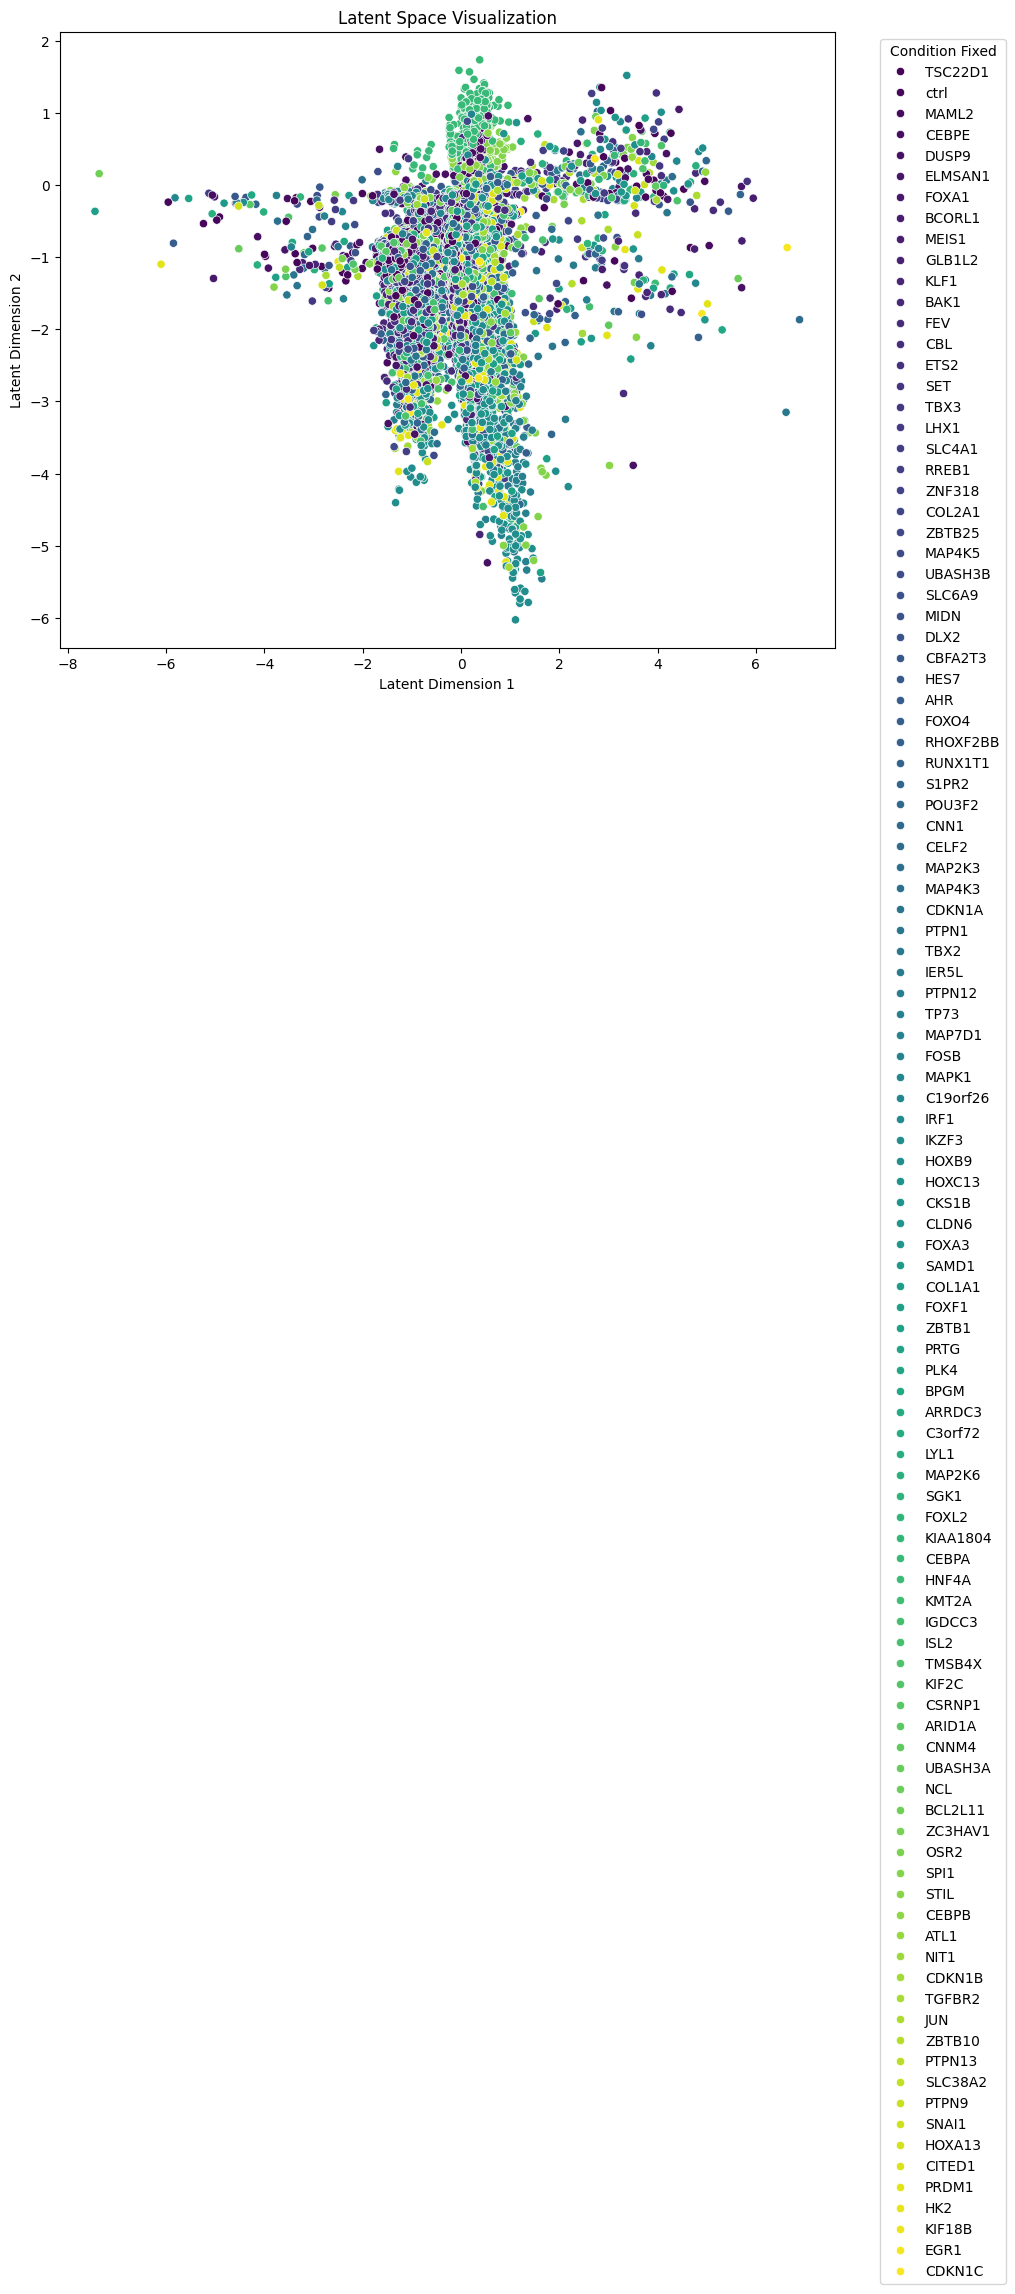

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the latent representations (z) for all data points
with torch.no_grad():
    _, z = autoencoder(X)

# Convert z to a numpy array for plotting
z = z.cpu().numpy()

# Get the condition_fixed values for the filtered data (adata_single_top_genes)
# This ensures the length of condition_fixed matches the length of z
condition_fixed = adata_single_top_genes.obs["condition_fixed"].values

# Create a scatter plot with colors based on condition_fixed
plt.figure(figsize=(10, 8))
sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=condition_fixed, palette="viridis")
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend(title="Condition Fixed", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

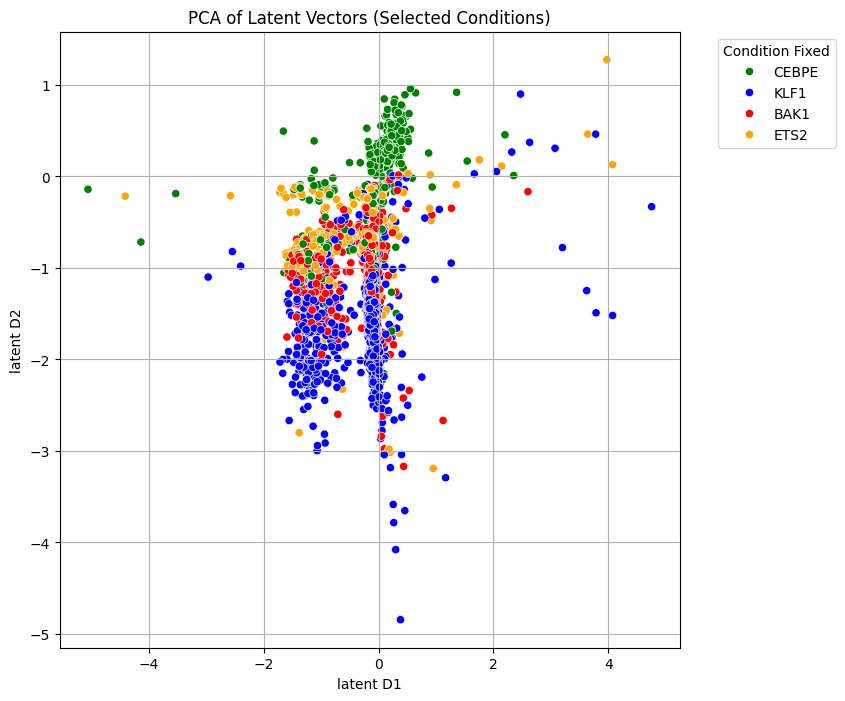

In [50]:
# Filter data for specific condition_fixed values
selected_conditions = ["KLF1", "BAK1", "CEBPE", "ETS2"]
filter_mask = np.isin(condition_fixed, selected_conditions)
filtered_z_2d = z[filter_mask]
filtered_condition_fixed = condition_fixed[filter_mask]

# Define a custom color palette with distinct colors
custom_palette = {"KLF1": "blue", "BAK1": "red", "CEBPE": "green", "ETS2": "orange"}
# Visualize the 2D PCA results using seaborn.scatterplot with custom palette
plt.figure(figsize=(8, 8))
sns.scatterplot(x=filtered_z_2d[:, 0], y=filtered_z_2d[:, 1],
                hue=filtered_condition_fixed, palette=custom_palette)
plt.title("PCA of Latent Vectors (Selected Conditions)")
plt.xlabel("latent D1")
plt.ylabel("latent D2")
plt.grid(True)
plt.legend(title="Condition Fixed", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 256), # We flatten the image - 28 x 28 = 784
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            #nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

G = generator()
D = discriminator()

batch_size = 64
epochs = 200
lr = 0.0002
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
# Code adopted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# This takes some time :(
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) same as minimizing BCE
        ###########################
        ## Train with all-real batch
        d_optimizer.zero_grad()
        b_size = data[0].size(0)
        #data[0] has shape (64, 1, 28, 28) ---> (64, 28, 28)
        # squeese(1) removes the second dimension if its size is 1 (the channel dimension in grayscale images).
        real_data = data[0].squeeze(1).reshape(b_size, -1) # Flatten the real images to match the Discriminator's input dimensions.
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        output = D(real_data).view(-1)  #view(-1) converts (batch size,1) to 1D tensor (batch size,)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128) #128 is the size of latent vector
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label) #Modifies the existing label tensor by filling all its values with the value of fake_label.
        # Classify all fake batch with D
        #print(fake.shape)
        output = D(fake.detach()).view(-1) #detach() ensures that the generator's weights are not updated during this step.

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        d_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z))) or minimize -log(D(G(z)))
        ###########################
        g_optimizer.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        # Update G
        g_optimizer.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

    if epoch % 10 == 1:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')
